#Libraries & Environment Setup

In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
GPU Devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
!pip install segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00


In [3]:
import os

os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

sm.set_framework('tf.keras')

Segmentation Models: using `tf.keras` framework.


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure, filters, morphology, transform
import tensorflow as tf
import glob
import os
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
import json
import random
import shutil
from segmentation_models.metrics import IOUScore, FScore
from segmentation_models import Unet
import cv2

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Paths

In [6]:
images_dir = "/content/drive/MyDrive/LXTHON EYE CHALLENGE FILES/train_dataset_mc/"
model_dir = "/content/drive/MyDrive/LXthon"
test_dir = "/content/drive/MyDrive/LXTHON EYE CHALLENGE FILES/test_dataset_mc/eye_test/"
solution_dir = "/content/drive/MyDrive/LXTHON EYE CHALLENGE FILES/test_ground_truth/eye_mask/"
mask_dir = "/content/masks/"
output = "/content/drive/MyDrive/LXthon/predictions"

#Data Preprocessing

In [7]:
def convert_folder_to_masks(
        image_dir,
        mask_suffix="_mask.png",
        masks_subfolder="masks",
        output_dir=None
    ):
    """
    For every .png in image_dir, looks for a same-named .geojson,
    rasterizes its polygons into an 8-bit binary mask (0 background, 255 vessels),
    and saves it as <basename>_mask.png.
    Tries to create a 'masks' subfolder inside image_dir (or uses output_dir if provided).
    Falls back to local './masks' if target is not writable.
    Handles Polygon and MultiPolygon geometries; casts coords to ints.

    Supports GeoJSON with a top-level dict {{ 'features': [...] }} or a list of features directly.
    """
    # Determine masks directory
    if output_dir:
        masks_dir = output_dir
    else:
        masks_dir = os.path.join(image_dir, masks_subfolder)

    # Attempt to create masks directory, fall back if necessary
    try:
        os.makedirs(masks_dir, exist_ok=True)
    except OSError as e:
        print(f"⚠️ Cannot create {masks_dir} ({e}), falling back to './{masks_subfolder}'")
        masks_dir = os.path.abspath(masks_subfolder)
        os.makedirs(masks_dir, exist_ok=True)

    print(f"Saving masks into: {masks_dir}")

    for fname in os.listdir(image_dir):
        if not fname.lower().endswith('.png'):
            continue

        base, _ = os.path.splitext(fname)
        img_path = os.path.join(image_dir, fname)
        geo_path = os.path.join(image_dir, base + '.geojson')
        mask_path = os.path.join(masks_dir, base + mask_suffix)

        if not os.path.exists(geo_path):
            print(f"→ skipping {fname}: no {base}.geojson found")
            continue

        # Load image for size
        img = Image.open(img_path)
        w, h = img.size

        # Prepare blank mask (8-bit)
        mask = Image.new('L', (w, h), 0)
        draw = ImageDraw.Draw(mask)

        # Load annotations
        with open(geo_path, 'r') as f:
            gj = json.load(f)

        # Extract feature list, support dict or list
        if isinstance(gj, dict) and 'features' in gj:
            features = gj['features']
        elif isinstance(gj, list):
            features = gj
        else:
            print(f"→ warning: unexpected GeoJSON format in {geo_path}")
            continue

        # Draw each polygon using white (255)
        for feat in features:
            geom = feat.get('geometry') if isinstance(feat, dict) else None
            if not geom:
                continue
            geom_type = geom.get('type')
            coords = geom.get('coordinates', [])

            def draw_poly(rings):
                for ring in rings:
                    pts = [(int(round(x)), int(round(y))) for x, y in ring]
                    if len(pts) >= 3:
                        draw.polygon(pts, outline=255, fill=255)

            if geom_type == 'Polygon':
                draw_poly(coords)
            elif geom_type == 'MultiPolygon':
                for poly in coords:
                    draw_poly(poly)
            else:
                print(f"→ warning: unsupported geometry type {geom_type} in {geo_path}")

        # Save mask (pixels 0 or 255 now visible)
        mask.save(mask_path)
        print(f"✓ wrote mask: {mask_path}")


In [8]:
convert_folder_to_masks(images_dir)

⚠️ Cannot create /content/drive/MyDrive/LXTHON EYE CHALLENGE FILES/train_dataset_mc/masks ([Errno 30] Read-only file system: '/content/drive/MyDrive/LXTHON EYE CHALLENGE FILES/train_dataset_mc/masks'), falling back to './masks'
Saving masks into: /content/masks
✓ wrote mask: /content/masks/164_mask.png
✓ wrote mask: /content/masks/157_mask.png
✓ wrote mask: /content/masks/182_mask.png
✓ wrote mask: /content/masks/163_mask.png
✓ wrote mask: /content/masks/159_mask.png
✓ wrote mask: /content/masks/187_mask.png
✓ wrote mask: /content/masks/173_mask.png
✓ wrote mask: /content/masks/219_mask.png
✓ wrote mask: /content/masks/225_mask.png
✓ wrote mask: /content/masks/212_mask.png
✓ wrote mask: /content/masks/218_mask.png
✓ wrote mask: /content/masks/216_mask.png
✓ wrote mask: /content/masks/194_mask.png
✓ wrote mask: /content/masks/220_mask.png
✓ wrote mask: /content/masks/211_mask.png
✓ wrote mask: /content/masks/223_mask.png
✓ wrote mask: /content/masks/222_mask.png
✓ wrote mask: /content/m

In [9]:
def load_data(
    image_dir,
    masks_subfolder='masks',
    mask_suffix='_mask.png',
    input_shape=(512, 512, 3)
):
    """
    Loads images and masks from disk, resizes them to input_shape,
    and returns NumPy arrays ready for training.

    Args:
        image_dir: path containing image .png files
        masks_subfolder: subfolder under image_dir where masks live
        mask_suffix: suffix added to image basename for masks
        input_shape: (H, W, C) target size and channels (3 for RGB)

    Returns:
        X: np.ndarray, shape (N, H, W, C), dtype float32, values [0,1]
        y: np.ndarray, shape (N, H, W, 1), dtype float32, values [0,1]
    """
    import os
    import numpy as np
    from PIL import Image

    H, W, C = input_shape
    imgs, msks = [], []

    masks_dir = os.path.join(image_dir, masks_subfolder)

    # Validate directories exist
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    if not os.path.exists(masks_dir):
        raise FileNotFoundError(f"Masks directory not found: {masks_dir}")

    loaded_count = 0
    for fname in sorted(os.listdir(image_dir)):
        if not fname.lower().endswith('.png'):
            continue

        base, _ = os.path.splitext(fname)  # Fixed: proper unpacking
        img_path = os.path.join(image_dir, fname)  # Fixed: removed asterisk
        mask_path = os.path.join(masks_dir, base + mask_suffix)

        if not os.path.exists(mask_path):
            print(f"→ warning: mask missing for {fname}, skipping")
            continue

        try:
            # Load and resize image
            img = Image.open(img_path).convert('RGB')
            img = img.resize((W, H), Image.BILINEAR)
            img_np = np.array(img, dtype=np.float32) / 255.0

            # Load and resize mask
            mask = Image.open(mask_path).convert('L')
            mask = mask.resize((W, H), Image.NEAREST)
            mask_np = np.array(mask, dtype=np.float32) / 255.0
            mask_np = mask_np[..., None]  # Add channel dimension

            imgs.append(img_np)
            msks.append(mask_np)
            loaded_count += 1

        except Exception as e:
            print(f"→ error loading {fname}: {e}")
            continue

    if loaded_count == 0:
        raise ValueError("No valid image-mask pairs found!")

    print(f"Loaded {loaded_count} image-mask pairs")

    X = np.stack(imgs, axis=0)
    y = np.stack(msks, axis=0)

    print(f"Final shapes: X={X.shape}, y={y.shape}")

    return X, y


In [10]:
X, y = load_data(
    images_dir,
    mask_dir,
    input_shape=(512, 512, 3)
)

X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=42)

→ warning: mask missing for 176.png, skipping
→ warning: mask missing for 202 .png, skipping
→ warning: mask missing for 233.png, skipping
→ warning: mask missing for 248 .png, skipping
→ warning: mask missing for 257.png, skipping
→ warning: mask missing for 377.png, skipping
→ warning: mask missing for 379.png, skipping
→ warning: mask missing for 391.png, skipping
→ warning: mask missing for 419.png, skipping
→ warning: mask missing for 442.png, skipping
→ warning: mask missing for 448.png, skipping
→ warning: mask missing for 622.png, skipping
→ warning: mask missing for 647.png, skipping
→ warning: mask missing for 683.png, skipping
Loaded 641 image-mask pairs
Final shapes: X=(641, 512, 512, 3), y=(641, 512, 512, 1)


In [11]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

X_train shape: (512, 512, 512, 3)
Y_train shape: (512, 512, 512, 1)
X_val shape: (129, 512, 512, 3)
Y_val shape: (129, 512, 512, 1)


In [12]:
print("X_train range:", X_train.min(), "to", X_train.max())
print("Y_train range:", Y_train.min(), "to", Y_train.max())

X_train range: 0.0 to 1.0
Y_train range: 0.0 to 1.0


In [13]:
def create_dataset(X, Y, batch_size=8):
  """
    Creates an optimized TensorFlow dataset from input arrays for training or validation.

    Takes NumPy arrays of images and masks, creates batches, and applies prefetching
    for optimal performance during model training.

    Args:
        X (np.ndarray): Input images array with shape (n_samples, height, width, channels).
                       Values should be normalized to [0, 1] range.
        Y (np.ndarray): Target masks array with shape (n_samples, height, width, 1).
                       Values should be normalized to [0, 1] range.
        batch_size (int, optional): Number of samples per batch. Defaults to 8.

    Returns:
        tf.data.Dataset: Batched and prefetched TensorFlow dataset ready for training.
                        Each batch contains (batch_images, batch_masks) tuples.

    Example:
        >>> X_train, y_train = load_data('train_images/')
        >>> train_dataset = create_dataset(X_train, y_train, batch_size=16)
        >>> model.fit(train_dataset, epochs=10)

    Note:
        - Uses tf.data.AUTOTUNE for automatic prefetch buffer tuning
        - Prefetching overlaps data preprocessing with model execution for better performance
        - Input arrays are converted to tf.data.Dataset using from_tensor_slices()
    """
  dataset = tf.data.Dataset.from_tensor_slices((X, Y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

train_dataset = create_dataset(X_train, Y_train, batch_size=8)
val_dataset = create_dataset(X_val, Y_val, batch_size=8)

#Model Architecture & Training

In [15]:
# Create UNet++ with transformer model

model = sm.Unet(
    backbone_name='efficientnetb7',
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid'
)

# Define metrics
metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5),
]

dice_loss = sm.losses.DiceLoss()
bce_loss  = sm.losses.BinaryCELoss()
total_loss = dice_loss + bce_loss

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=total_loss,
    metrics=metrics,
)


258434480/258434480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
# Callbacks employed
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras',
                                       monitor='val_loss',
                                       mode='min',  # Fixed
                                       save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.5,
                                         patience=5,
                                         min_lr=1e-7),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     patience=20,
                                     mode='min',
                                     restore_best_weights=True)
]

# Train with dataset
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=callbacks
)

Epoch 1/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 386s 918ms/step - f1-score: 0.0501 - iou_score: 0.0260 - loss: 1.7134 - val_f1-score: 0.0292 - val_iou_score: 0.0148 - val_loss: 3.3320 - learning_rate: 1.0000e-04
Epoch 2/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - f1-score: 0.2885 - iou_score: 0.1701 - loss: 1.2930 - val_f1-score: 0.1816 - val_iou_score: 0.1002 - val_loss: 1.5579 - learning_rate: 1.0000e-04
Epoch 3/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - f1-score: 0.3924 - iou_score: 0.2449 - loss: 1.1772 - val_f1-score: 0.3880 - val_iou_score: 0.2415 - val_loss: 1.3210 - learning_rate: 1.0000e-04
Epoch 4/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 345ms/step - f1-score: 0.4365 - iou_score: 0.2799 - loss: 1.1039 - val_f1-score: 0.4358 - val_iou_score: 0.2796 - val_loss: 1.1500 - learning_rate: 1.0000e-04
Epoch 5/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 345ms/step - f1-score: 0.4614 - iou_score: 0.3008 - loss: 1.0448 - val_f1-score: 0.4831 - val_iou_score: 0.3196 - val_loss: 1.0478 - learning_rate: 

#Metrics Plots

In [17]:
def plot_metrics(history):
    """
    Plots loss and metrics from a Keras History object.

    Args:
        history: tf.keras.callbacks.History returned by model.fit()
    """
    # Extract history dict
    h = history.history

    # Plot Loss
    plt.figure()
    plt.plot(h['loss'], label='train_loss')
    plt.plot(h['val_loss'], label='val_loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot each metric
    for key in h:
        if key in ('loss', 'val_loss'):
            continue
        plt.figure()
        plt.plot(h[key], label=f'train_{key}')
        val_key = 'val_' + key if not key.startswith('val_') else key
        if val_key in h:
            plt.plot(h[val_key], label=val_key)
        plt.title(f'{key} Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel(key)
        plt.legend()
        plt.show()

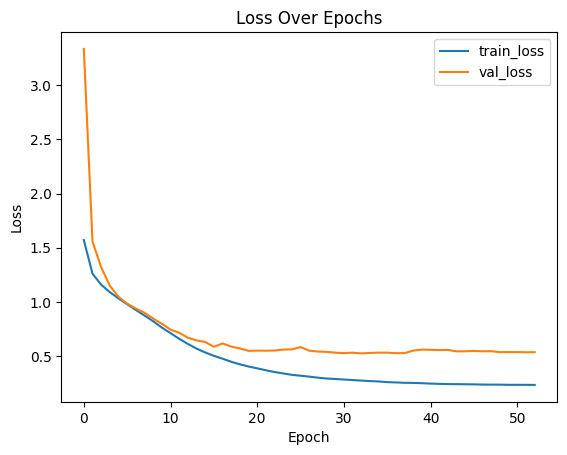

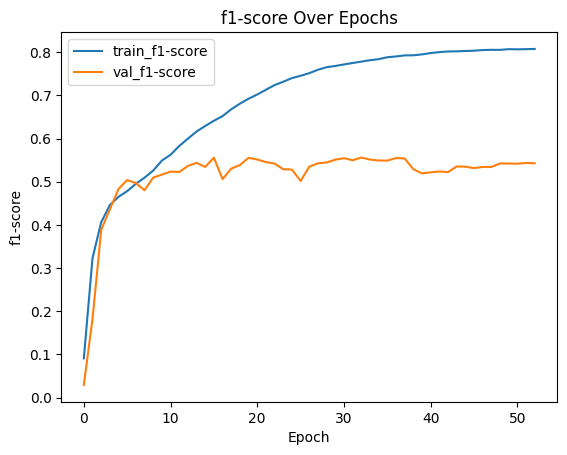

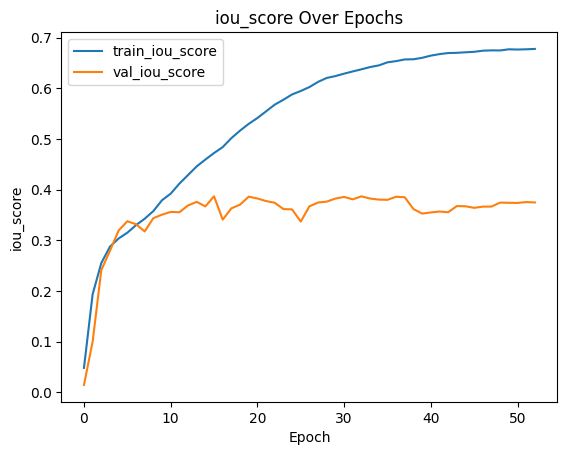

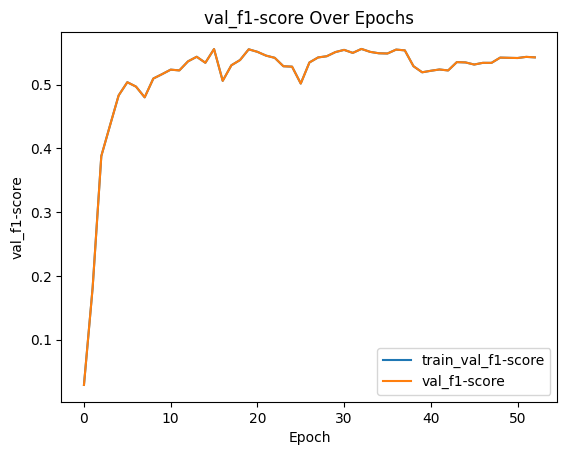

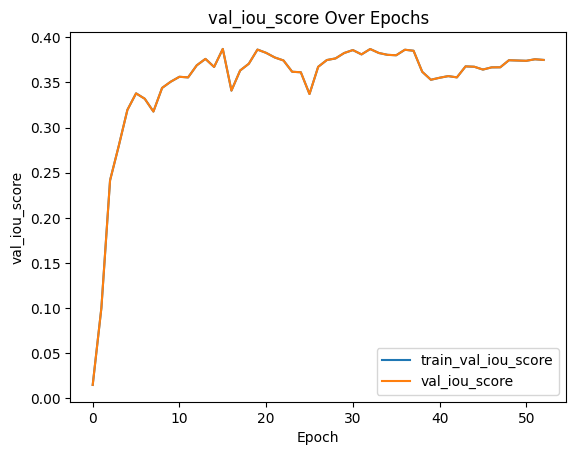

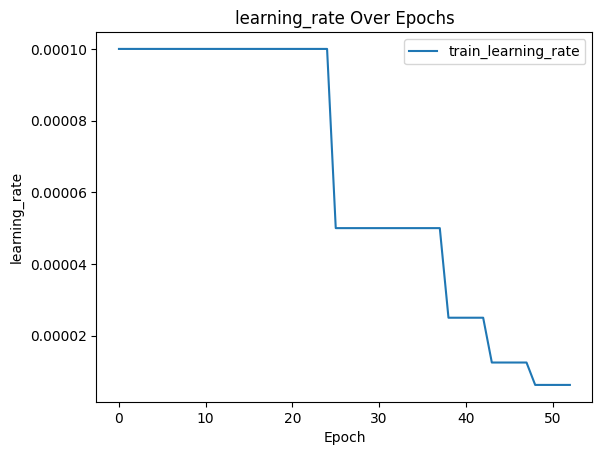

In [18]:
plot_metrics(history)

#Predictions & Results Visualization

In [29]:
def predict_test_set(
    model,
    test_dir,
    output_dir,
    input_shape=(512, 512, 3),
    batch_size=8,
    threshold=0.5
):
    """
    Uses a trained model to predict masks for test images and saves them to disk.

    Args:
        model: trained Keras/TensorFlow model
        test_dir: directory containing test images (e.g., 1000.png, 1001.png, etc.)
        output_dir: directory where predicted masks will be saved
        input_shape: (H, W, C) input size that matches model training
        batch_size: number of images to process at once
        threshold: threshold for converting probabilities to binary masks (0.0-1.0)

    Returns:
        predictions_info: dict with processing statistics
    """
    import os
    import numpy as np
    from PIL import Image
    import tensorflow as tf

    H, W, C = input_shape

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Validate test directory exists
    if not os.path.exists(test_dir):
        raise FileNotFoundError(f"Test directory not found: {test_dir}")

    # Get all test image files
    test_files = []
    for fname in sorted(os.listdir(test_dir)):
        if fname.lower().endswith('.png'):
            test_files.append(fname)

    if len(test_files) == 0:
        raise ValueError("No PNG files found in test directory!")

    print(f"Found {len(test_files)} test images")

    processed_count = 0
    failed_count = 0

    # Process images in batches
    for i in range(0, len(test_files), batch_size):
        batch_files = test_files[i:i + batch_size]
        batch_images = []
        batch_names = []

        # Load batch of images
        for fname in batch_files:
            try:
                img_path = os.path.join(test_dir, fname)

                # Load and preprocess image
                img = Image.open(img_path).convert('RGB')
                img = img.resize((W, H), Image.BILINEAR)
                img_np = np.array(img, dtype=np.float32) / 255.0

                batch_images.append(img_np)
                batch_names.append(fname)

            except Exception as e:
                print(f"→ error loading {fname}: {e}")
                failed_count += 1
                continue

        if len(batch_images) == 0:
            continue

        # Convert to numpy array and predict
        try:
            batch_array = np.stack(batch_images, axis=0)
            predictions = model.predict(batch_array, verbose=0)

            # Process each prediction in the batch
            for j, (pred, fname) in enumerate(zip(predictions, batch_names)):
                try:
                    # Apply threshold and convert to binary mask
                    binary_mask = (pred.squeeze() > threshold).astype(np.uint8) * 255

                    # Convert to PIL Image and save
                    mask_img = Image.fromarray(binary_mask, mode='L')

                    # Save with same filename as input
                    base_name = os.path.splitext(fname)[0]
                    output_path = os.path.join(output_dir, f"{base_name}.png")
                    mask_img.save(output_path)

                    processed_count += 1

                except Exception as e:
                    print(f"→ error saving prediction for {fname}: {e}")
                    failed_count += 1
                    continue

            print(f"Processed batch {i//batch_size + 1}/{(len(test_files) + batch_size - 1)//batch_size}")

        except Exception as e:
            print(f"→ error predicting batch starting at {batch_files[0]}: {e}")
            failed_count += len(batch_images)
            continue

    predictions_info = {
        'total_files': len(test_files),
        'processed': processed_count,
        'failed': failed_count,
        'output_dir': output_dir,
        'threshold_used': threshold
    }

    print(f"\nPrediction complete!")
    print(f"Successfully processed: {processed_count}/{len(test_files)} images")
    print(f"Failed: {failed_count} images")
    print(f"Predictions saved to: {output_dir}")

    return predictions_info

In [38]:
info = predict_test_set(
    model=model,
    test_dir=test_dir,
    output_dir=output,
    batch_size=8,
    threshold=0.5
)

Found 307 test images
Processed batch 1/39
Processed batch 2/39
Processed batch 3/39
Processed batch 4/39
Processed batch 5/39
Processed batch 6/39
Processed batch 7/39
Processed batch 8/39
Processed batch 9/39
Processed batch 10/39
Processed batch 11/39
Processed batch 12/39
Processed batch 13/39
Processed batch 14/39
Processed batch 15/39
Processed batch 16/39
Processed batch 17/39
Processed batch 18/39
Processed batch 19/39
Processed batch 20/39
Processed batch 21/39
Processed batch 22/39
Processed batch 23/39
Processed batch 24/39
Processed batch 25/39
Processed batch 26/39
Processed batch 27/39
Processed batch 28/39
Processed batch 29/39
Processed batch 30/39
Processed batch 31/39
Processed batch 32/39
Processed batch 33/39
Processed batch 34/39
Processed batch 35/39
Processed batch 36/39
Processed batch 37/39
Processed batch 38/39
Processed batch 39/39

Prediction complete!
Successfully processed: 307/307 images
Failed: 0 images
Predictions saved to: /content/drive/MyDrive/LXthon

In [35]:
from sklearn.metrics import f1_score

def compute_folder_f1(pred_dir: str, gt_dir: str) -> dict:
    """
    Compute per-image F1 scores between predicted masks and ground-truth masks,
    ignoring any files that don’t have a counterpart in the other folder.
    If a prediction and its ground truth differ in size, the prediction is
    resized to match the GT before thresholding.

    Args:
        pred_dir: Path to folder containing predicted binary mask images.
        gt_dir:   Path to folder containing ground-truth binary mask images.

    Returns:
        A dict mapping each filename (common to both dirs) to its F1 score.
    """
    # Get filenames present in both folders
    preds = set(os.listdir(pred_dir))
    gts   = set(os.listdir(gt_dir))
    common = sorted(preds & gts)

    f1_scores = {}
    for fname in common:
        # Load as PIL images
        pred_img = Image.open(os.path.join(pred_dir, fname)).convert('L')
        gt_img   = Image.open(os.path.join(gt_dir,   fname)).convert('L')

        # Resize prediction to match ground-truth size if needed
        if pred_img.size != gt_img.size:
            pred_img = pred_img.resize(gt_img.size, resample=Image.NEAREST)

        # Convert to numpy arrays
        pred_arr = np.array(pred_img)
        gt_arr   = np.array(gt_img)

        # Binarize (threshold at 128 out of 255)
        pred_bin = (pred_arr >= 128).astype(np.uint8).ravel()
        gt_bin   = (gt_arr   >= 128).astype(np.uint8).ravel()

        # Compute F1
        f1_scores[fname] = f1_score(gt_bin, pred_bin)

    return f1_scores


scores = compute_folder_f1(output, solution_dir)
mean_f1 = sum(scores.values()) / len(scores)

In [37]:
mean_f1

0.654491750337115

In [45]:
def visualize_eye_blood_vessels(eye_image_path, vessel_mask_path,
                               vessel_color=(255, 0, 0), alpha=0.6,
                               figsize=(15, 5), save_path=None):
    """
    Visualize eye image with predicted blood vessels highlighted.

    Parameters:
    -----------
    eye_image_path : str
        Path to the original eye/retinal image
    vessel_mask_path : str
        Path to the predicted blood vessel mask/segmentation
    vessel_color : tuple
        RGB color for highlighting vessels (default: red)
    alpha : float
        Transparency level for vessel overlay (0-1)
    figsize : tuple
        Figure size for the plot
    save_path : str, optional
        Path to save the combined visualization

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    """

    # Load images
    try:
        eye_img = Image.open(eye_image_path).convert('RGB')
        vessel_mask = Image.open(vessel_mask_path).convert('L')  # Convert to grayscale
    except Exception as e:
        raise ValueError(f"Error loading images: {e}")

    # Convert to numpy arrays
    eye_array = np.array(eye_img)
    vessel_array = np.array(vessel_mask)

    # Ensure images have the same dimensions
    if eye_array.shape[:2] != vessel_array.shape:
        # Resize vessel mask to match eye image
        vessel_mask_resized = vessel_mask.resize(eye_img.size, Image.LANCZOS)
        vessel_array = np.array(vessel_mask_resized)

    # Normalize vessel mask to 0-1 range
    if vessel_array.max() > 1:
        vessel_array = vessel_array / 255.0

    # Create overlay image
    overlay = create_vessel_overlay(eye_array, vessel_array, vessel_color, alpha)

    # Create the visualization
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Original eye image
    axes[0].imshow(eye_array)
    axes[0].set_title('Original Eye Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Predicted blood vessels
    axes[1].imshow(vessel_array, cmap='gray')
    axes[1].set_title('Predicted Blood Vessels', fontsize=12, fontweight='bold')
    axes[1].axis('off')

    # Combined visualization
    axes[2].imshow(overlay)
    axes[2].set_title('Eye with Highlighted Vessels', fontsize=12, fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")

    plt.show()
    return fig

def create_vessel_overlay(eye_image, vessel_mask, vessel_color, alpha):
    """
    Create an overlay of blood vessels on the eye image.

    Parameters:
    -----------
    eye_image : numpy.ndarray
        Original eye image (RGB)
    vessel_mask : numpy.ndarray
        Binary or grayscale vessel mask
    vessel_color : tuple
        RGB color for vessels
    alpha : float
        Transparency level

    Returns:
    --------
    numpy.ndarray
        Combined image with highlighted vessels
    """
    # Create a copy of the original image
    overlay = eye_image.copy().astype(np.float64)

    # Create colored vessel mask
    vessel_colored = np.zeros_like(eye_image, dtype=np.float64)

    # Apply vessel color where vessels are present
    vessel_mask_3d = np.stack([vessel_mask] * 3, axis=-1)
    vessel_colored = vessel_mask_3d * np.array(vessel_color)

    # Blend the images
    result = overlay * (1 - alpha * vessel_mask_3d) + vessel_colored * alpha

    # Ensure values are in valid range
    result = np.clip(result, 0, 255).astype(np.uint8)

    return result

In [46]:
image_path = '/content/drive/MyDrive/LXthon/LXTHON EYE CHALLENGE FILES-20250613T111124Z-1-001/LXTHON EYE CHALLENGE FILES/test_dataset_mc/eye_test/1000.png'
result_img = '/content/drive/MyDrive/LXthon/predictions/1000.png'

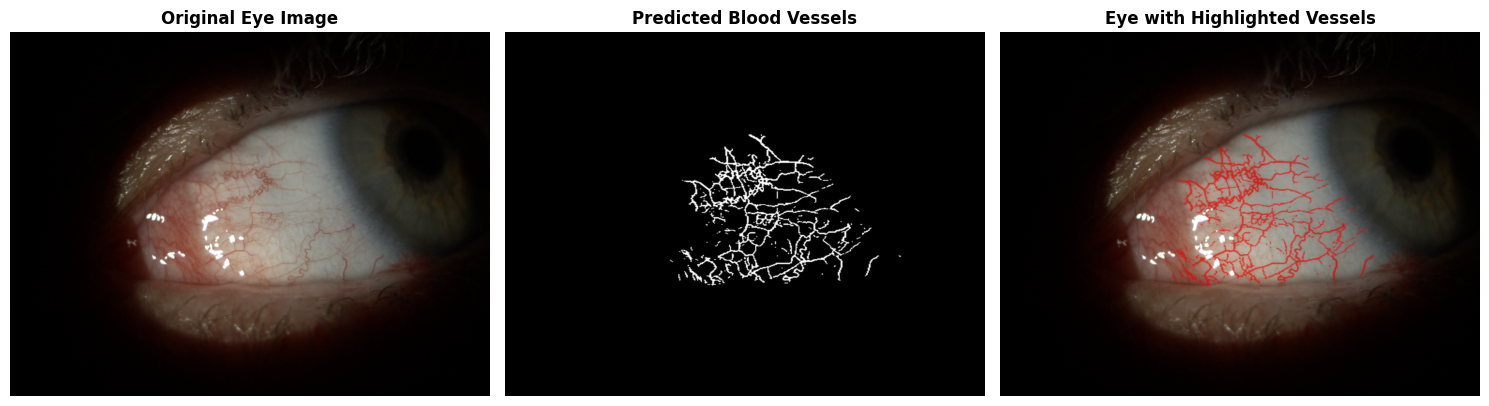

In [47]:
fig = visualize_eye_blood_vessels(image_path, result_img)